In [7]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [8]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram

Generation of the covariance matrix and normalization

In [9]:
#number of features
N = 4

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)

covmat = np.dot(centered.transpose(),centered)
covmat=covmat/np.trace(covmat)
print(covmat)
eigval, eigvec = np.linalg.eig(covmat)
print("Eigenvalues: ")
print(eigval)
print("Eigenvectors: ")
print(eigvec)

[[ 0.22325321 -0.02181576 -0.0785794   0.13732288]
 [-0.02181576  0.2528709   0.03668986  0.13220711]
 [-0.0785794   0.03668986  0.25223403  0.00509261]
 [ 0.13732288  0.13220711  0.00509261  0.27164186]]
Eigenvalues: 
[0.04505501 0.43784417 0.33754706 0.17955376]
Eigenvectors: 
[[ 0.61652716  0.46329     0.49927814  0.39494048]
 [ 0.43654886  0.46474758 -0.52266859 -0.5659084 ]
 [ 0.17206909 -0.08369437 -0.68831291  0.69972339]
 [-0.63222748  0.74991154 -0.06135327  0.1848158 ]]


In [10]:
bits = 3
#initial =[ 0.28526355, -0.14474718, -0.02720251,  0.03417223]
initial = None
res=qpca(covmat,bits,initialeig= initial ,iterations=1)

print(res.get_eigvals())

first_approx [0.5 0.5 0.5 0.5]
last_approx [ 0.48057989  0.44797722 -0.4195538   0.6263657 ]
[(0.875, 144), (0.75, 149), (0.625, 319), (0.0, 624), (0.25, 791), (0.125, 843), (0.5, 2236), (0.375, 3086)]


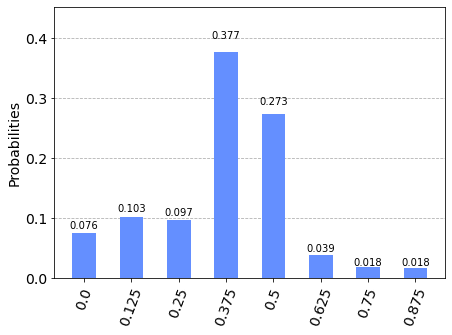

In [11]:
plot_histogram(res.get_eigvals(False))

In [12]:
eigval_to_find = 0.5
eigv = res.eigvec_from_eigval(eigval_to_find)
print(eigv)

[0.45676372 0.47793019 0.12722834 0.73943397]
